In [ ]:
pip install --upgrade tensorflow jax jaxlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 26.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.3/87.3 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 33.3 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.1
    Uninstalling tensorboard-2.17.1:
      Successfully uninstalled tensorboard-2.17.1
  Attempting uninstall: jaxlib
    Found existing installation: jaxlib 0.4.33
    Uninstalling jaxlib-0.4.33:
      Successfully uninstalled jaxlib-0.4.33
  Attempting uninstall: jax
    Found existing installation: jax 0.4.33
    Uninstalling jax-0.4.33:
      Successfully uninstalled jax-0.4.33
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.17.1
    Uninstalling tensorflow-2.17.1:
      Successfully uninstalled tensorflow-2.17.1
ERROR: pip's dependency resolver does not cu

In [ ]:
pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 12.5 MB/s eta 0:00:00


In [ ]:
pip install keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.9 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load the load data
load_data = pd.read_csv('21-24_Load_Data.csv')

# Convert hour_data to datetime
load_data['hour_data'] = pd.to_datetime(load_data['hour_data'], format='%m/%d/%Y %H:%M', errors='coerce')

# Drop rows with invalid datetime values
load_data = load_data.dropna(subset=['hour_data'])

# Remove every 24th row to avoid midnight issues
load_data = load_data[~load_data.index.isin(range(23, len(load_data), 24))]

# Ensure load data has datetime index
load_data.set_index('hour_data', inplace=True)

# Clean the 'previous_load_demand' column by removing commas and convert it to float
load_data['previous_load_demand'] = load_data['previous_load_demand'].str.replace(',', '').astype('float64')

# Resample load data to daily frequency by averaging
load_data_daily = load_data.resample('D').mean()

# Print the head of load data
print("Load data head:")
print(load_data_daily.head())
print("Load data date range:", load_data_daily.index.min(), "to", load_data_daily.index.max())


Load data head:
            previous_load_demand
hour_data                       
2020-01-01           3564.551818
2020-01-02           3556.683182
2020-01-03           3541.433636
2020-01-04           3528.200909
2020-01-05           3363.934091
Load data date range: 2020-01-01 00:00:00 to 2024-04-30 00:00:00


In [ ]:
# Load the weather data
weather_data = pd.read_csv('WeatherData.csv', parse_dates=['DATE'])

# Convert DATE to datetime
weather_data['DATE'] = pd.to_datetime(weather_data['DATE'])

# Resample weather data to daily frequency and forward fill to match load data frequency
weather_data = weather_data.set_index('DATE').resample('D').ffill()

# Print the head of weather data
print("Weather data head:")
print(weather_data.head())
print("Weather data date range:", weather_data.index.min(), "to", weather_data.index.max())

Weather data head:
            WIND SPEED  PRCP  SNOW  Snow Depth  TMAX  TMIN
DATE                                                      
2020-01-01        3.58   0.0   0.0         0.0    58    50
2020-01-02        2.91   0.0   0.0         0.0    60    49
2020-01-03        6.71   0.0   0.0         0.0    66    49
2020-01-04        4.25   0.0   0.0         0.0    73    44
2020-01-05        2.68   0.0   0.0         0.0    76    45
Weather data date range: 2020-01-01 00:00:00 to 2024-05-26 00:00:00


In [ ]:
# Load the usage data
usage_data = pd.read_csv('PreviousOutageDates.csv', parse_dates=['Date'])

# Convert Date to datetime
usage_data['Date'] = pd.to_datetime(outage_data['Date'])

# Resample outage data to daily frequency and forward fill to match load data frequency
usage_data = outage_data.set_index('Date').resample('D').ffill()

# Print the head of usage data
print("Usage data head:")
print(usage_data.head())
print("Usage data date range:", usage_data.index.min(), "to", usage_data.index.max())


Outage data head:
            Cause
Date             
2020-01-01      0
2020-01-02      0
2020-01-03      0
2020-01-04      0
2020-01-05      0
Outage data date range: 2020-01-01 00:00:00 to 2024-04-30 00:00:00


In [ ]:
# Filter outage data to only relevant dates
outage_data = outage_data[(outage_data.index >= load_data_daily.index.min()) & (outage_data.index <= load_data_daily.index.max())]

# Merge load data and weather data
data = load_data_daily.merge(weather_data.reset_index(), left_index=True, right_on='DATE', how='inner')
print("After merging load and weather data:")
print(data.head())

data.set_index('DATE', inplace=True)

# Merge outage data
data = data.merge(outage_data, left_index=True, right_on='Date', how='left')
print("After merging outage data:")
print(data.head())

# Reset index to monotonic incremental values
data.reset_index(drop=True, inplace=True)

# Interpolate missing values if any
data = data.interpolate(method='linear')

# Create lag features for previous load
for lag in range(1, 25):
    data[f'previous_load_demand_lag_{lag}'] = data['previous_load_demand'].shift(lag)

# Drop rows with NaN values created by lag features
data = data.dropna()

# Define features and targets
features = [col for col in data.columns if col.startswith('previous_load_demand_lag_') or col in ['WIND SPEED', 'PRCP', 'SNOW', 'Snow Depth', 'TMAX', 'TMIN', 'Cause']]
target_load = 'previous_load_demand'
target_outage = 'Cause'

# Prepare the features (X) and targets (y)
X = data[features]
y_load = data[target_load]
y_outage = data[target_outage]

# Final data check
print("Final data check:")
print("Features (X) head:")
print(X.head())
print("Target Load (y_load) head:")
print(y_load.head())
print("Target Outage (y_outage) head:")
print(y_outage.head())

print("Data preparation complete")

After merging load and weather data:
   previous_load_demand       DATE  WIND SPEED  PRCP  SNOW  Snow Depth  TMAX  \
0           3564.551818 2020-01-01        3.58   0.0   0.0         0.0    58   
1           3556.683182 2020-01-02        2.91   0.0   0.0         0.0    60   
2           3541.433636 2020-01-03        6.71   0.0   0.0         0.0    66   
3           3528.200909 2020-01-04        4.25   0.0   0.0         0.0    73   
4           3363.934091 2020-01-05        2.68   0.0   0.0         0.0    76   

   TMIN  
0    50  
1    49  
2    49  
3    44  
4    45  
After merging outage data:
            previous_load_demand  WIND SPEED  PRCP  SNOW  Snow Depth  TMAX  \
Date                                                                         
2020-01-01           3564.551818        3.58   0.0   0.0         0.0    58   
2020-01-02           3556.683182        2.91   0.0   0.0         0.0    60   
2020-01-03           3541.433636        6.71   0.0   0.0         0.0    66   
2020-

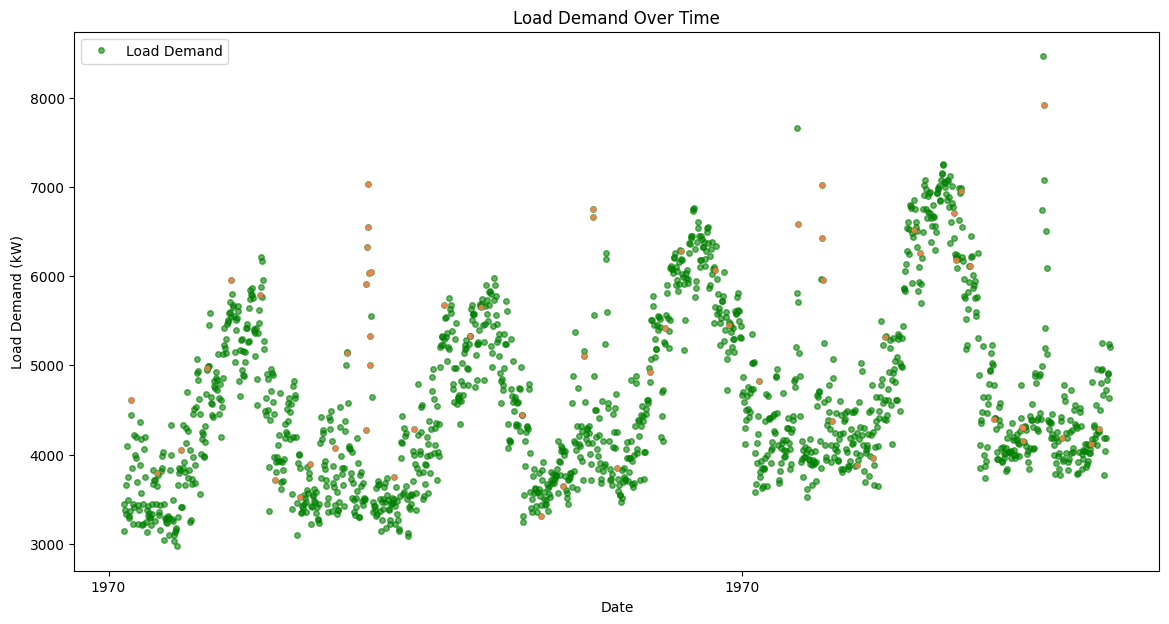

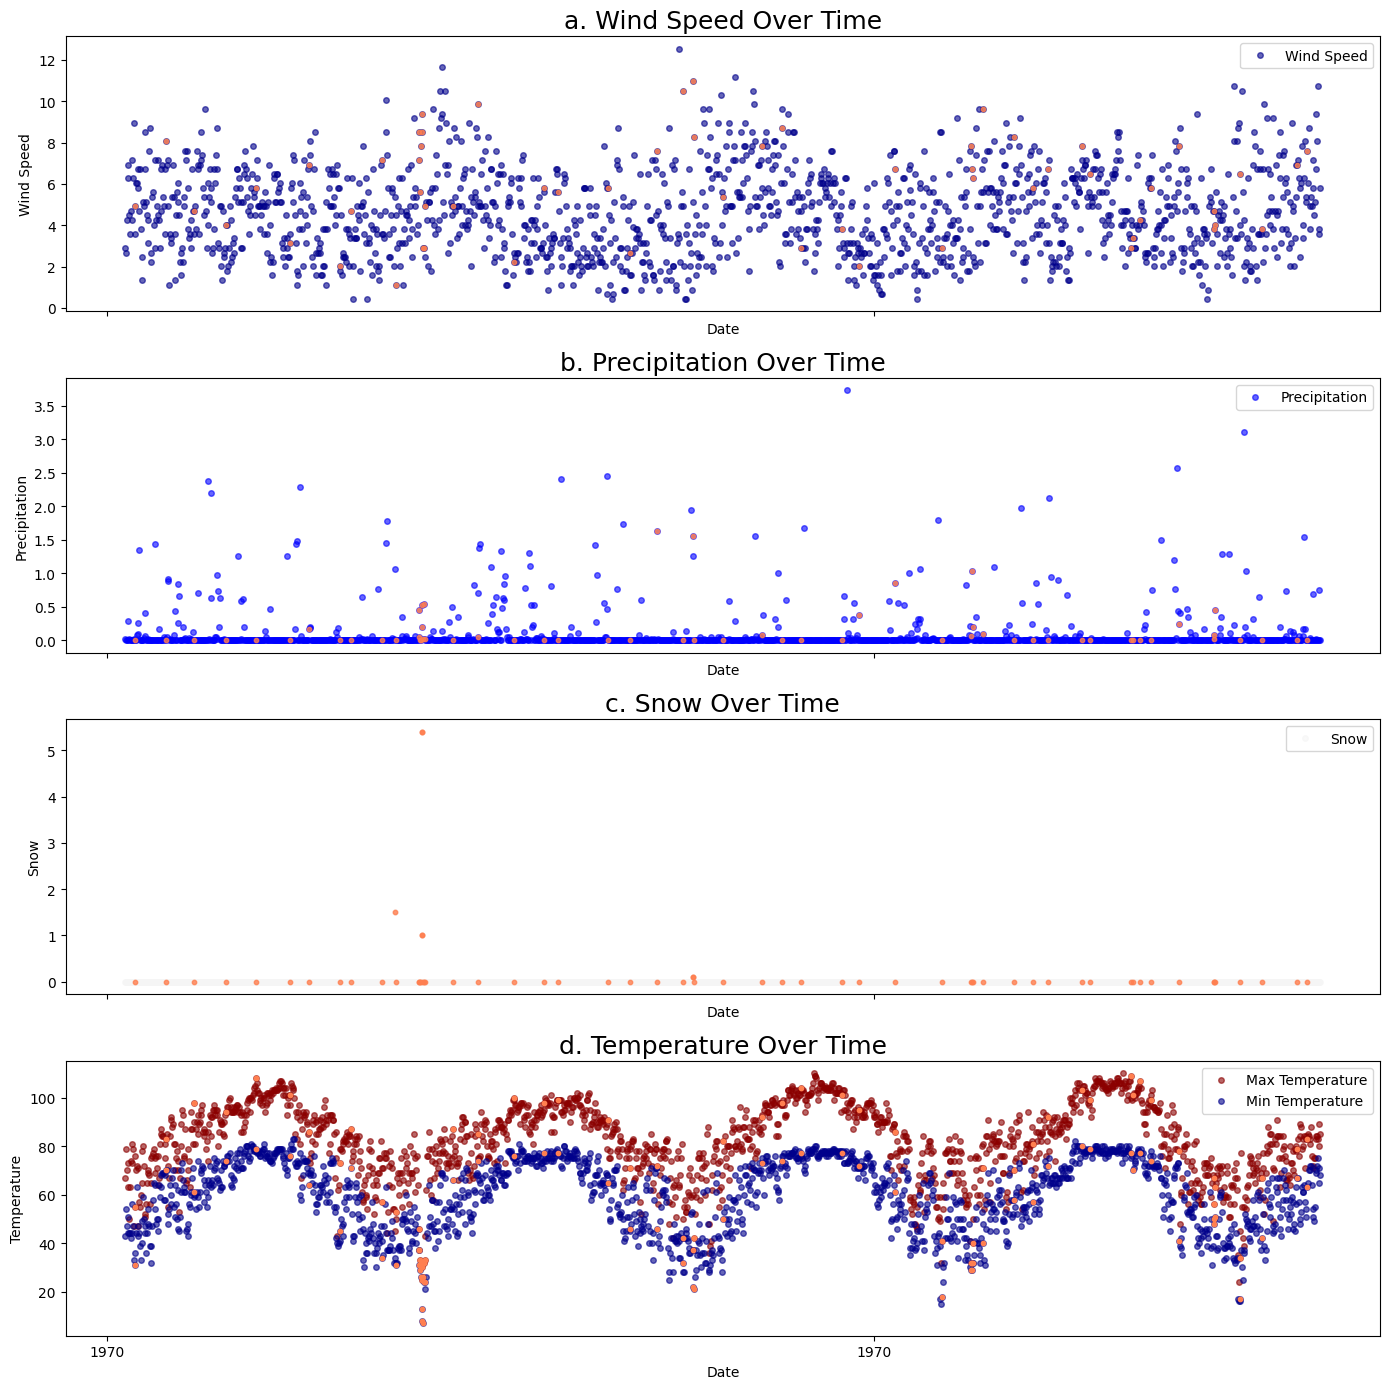

In [ ]:
# Define a function to plot with outage indicators
def plot_with_outages(ax, x, y, label, color='blue', scatter=False, bold_indices=None, alpha=0.6):
    ax.plot(x, y, label=label, color=color, linestyle='None', marker='o', markersize=4, alpha=alpha)
    if scatter and bold_indices is not None:
        ax.scatter(bold_indices, y[bold_indices], color='Coral', s=10, alpha=0.8, zorder=5)
    outage_dates = data[data['Cause'] > 0].index
    ax.scatter(outage_dates, y[outage_dates], color='Coral', s=10, alpha=0.8, zorder=5)
    ax.legend()

# Plot load data
plt.figure(figsize=(14, 7))
ax = plt.gca()
plot_with_outages(ax, data.index, data['previous_load_demand'], 'Load Demand', color='green', alpha=0.6)
plt.title('Load Demand Over Time')
plt.xlabel('Date')
plt.ylabel('Load Demand (kW)')
plt.show()

# Plot weather data
fig, ax = plt.subplots(4, 1, figsize=(14, 14), sharex=True)

# Wind Speed
plot_with_outages(ax[0], data.index, data['WIND SPEED'], 'Wind Speed', color='darkblue', alpha=0.6)
ax[0].set_title('a. Wind Speed Over Time', fontsize=18)
ax[0].set_ylabel('Wind Speed')
ax[0].set_xlabel('Date')


# Precipitation
plot_with_outages(ax[1], data.index, data['PRCP'], 'Precipitation', color='blue', alpha=0.6)
ax[1].set_title('b. Precipitation Over Time', fontsize=18)
ax[1].set_ylabel('Precipitation')
ax[1].set_xlabel('Date')


# Snow
non_zero_snow = data[data['SNOW'] > 0].index
plot_with_outages(ax[2], data.index, data['SNOW'], 'Snow', color='whitesmoke', scatter=True, bold_indices=non_zero_snow, alpha=0.6)
ax[2].set_title('c. Snow Over Time', fontsize=18)
ax[2].set_ylabel('Snow')
ax[2].set_xlabel('Date')


# Temperature
ax[3].plot(data.index, data['TMAX'], label='Max Temperature', color='darkred', linestyle='None', marker='o', markersize=4, alpha=0.6)
ax[3].plot(data.index, data['TMIN'], label='Min Temperature', color='darkblue', linestyle='None', marker='o', markersize=4, alpha=0.6)
outage_dates = data[data['Cause'] > 0].index
ax[3].scatter(outage_dates, data['TMAX'].loc[outage_dates], color='Coral', s=10, alpha=1.0, zorder=5)
ax[3].scatter(outage_dates, data['TMIN'].loc[outage_dates], color='Coral', s=10, alpha=1.0, zorder=5)
ax[3].set_title('d. Temperature Over Time', fontsize=18)
ax[3].set_xlabel('Date')
ax[3].set_ylabel('Temperature')
ax[3].legend()

plt.tight_layout()
plt.show()

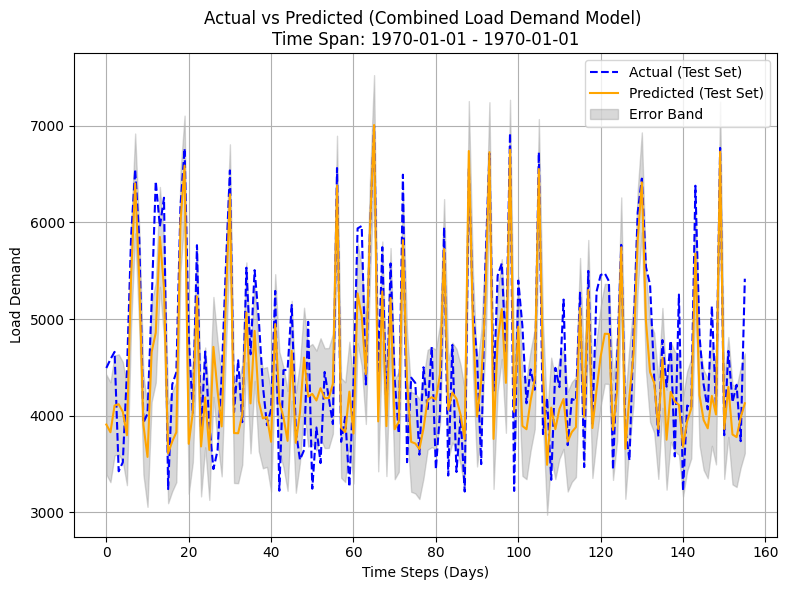

In [ ]:
# Calculate residuals and standard deviation for error bands
residuals_test = y_load_test - combined_pred_test
error_band = np.std(residuals_test)

# Example assuming you have a corresponding array of dates for y_load_test
start_date = data.index[len(data) - len(y_load_test)]  # Adjust indexing based on your data structure
end_date = data.index[-1]  # Assuming y_load_test spans to the end of the data

plt.figure(figsize=(8, 6))
plt.plot(y_load_test.values, label='Actual (Test Set)', linestyle='--', color='blue')
plt.plot(combined_pred_test, label='Predicted (Test Set)', color='orange')

upper_bound = combined_pred_test + error_band
lower_bound = combined_pred_test - error_band
plt.fill_between(np.arange(len(combined_pred_test)), lower_bound, upper_bound, color='gray', alpha=0.3, label='Error Band')

plt.title(f'Actual vs Predicted (Combined Load Demand Model) \nTime Span: {start_date.date()} - {end_date.date()}')
plt.xlabel('Time Steps (Days)')
plt.ylabel('Load Demand')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


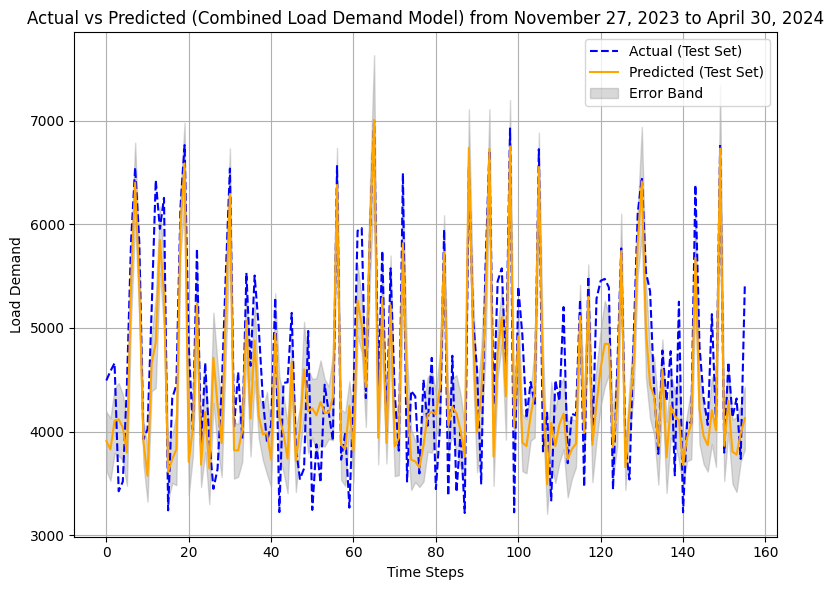

Time Span for the Plot: 1970-01-01 00:00:00.000001426 - 1970-01-01 00:00:00.000001581


In [ ]:
# Assuming `combined_pred_test` is your predicted values array and `errors` is the error array (e.g., standard deviation)
import matplotlib.pyplot as plt
import numpy as np

# Example errors (adjust these based on your actual data)
errors = np.random.uniform(low=0.05, high=0.1, size=len(combined_pred_test)) * combined_pred_test

# Plot actual vs predicted for load demand test set
plt.figure(figsize=(8, 6))
plt.plot(y_load_test.values, label='Actual (Test Set)', linestyle='--', color='blue')
plt.plot(combined_pred_test, label='Predicted (Test Set)', color='orange')

# Adding error bands around the predicted values
upper_bound = combined_pred_test + errors
lower_bound = combined_pred_test - errors
plt.fill_between(np.arange(len(combined_pred_test)), lower_bound, upper_bound, color='gray', alpha=0.3, label='Error Band')

plt.title('Actual vs Predicted (Combined Load Demand Model) from November 27, 2023 to April 30, 2024')
plt.xlabel('Time Steps')
plt.ylabel('Load Demand')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Assuming your y_load_test corresponds to the last portion of the data index
start_date = data.index[len(data) - len(y_load_test)]  # Adjust indexing based on your data structure
end_date = data.index[-1]  # Assuming y_load_test spans to the end of the data

# Printing the determined start and end dates
print(f"Time Span for the Plot: {start_date} - {end_date}")


In [ ]:
from sklearn.metrics import median_absolute_error, mean_squared_log_error

# Define function to calculate and display all metrics for a model
def evaluate_model(y_true, y_pred, model_name):
    # Mean Absolute Error (MAE)
    mae = mean_absolute_error(y_true, y_pred)
    # Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    # Mean Absolute Percentage Error (MAPE)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    # Median Absolute Error (MedAE)
    medae = median_absolute_error(y_true, y_pred)
    # Mean Squared Logarithmic Error (MSLE)
    msle = mean_squared_log_error(y_true, y_pred)
    # Mean Bias Deviation (MBD)
    mbd = mean_bias_deviation(y_true, y_pred)
    # Symmetric Mean Absolute Percentage Error (SMAPE)
    smape_val = smape(y_true, y_pred)
    # Theil's U-Statistic
    theils_u_val = theils_u(y_true, y_pred)
    # R-squared (R2)
    r2 = r2_score(y_true, y_pred)
    # Explained Variance (EV)
    ev = explained_variance_score(y_true, y_pred)
    # Max Error
    max_err = max_error(y_true, y_pred)

    # Display the metrics
    print(f"\nMetrics for {model_name}:")
    print(f"MAE: {mae}")
    print(f"RMSE: {rmse}")
    print(f"MAPE: {mape}%")
    print(f"Median Absolute Error (MedAE): {medae}")
    print(f"Mean Squared Logarithmic Error (MSLE): {msle}")
    print(f"Mean Bias Deviation (MBD): {mbd}")
    print(f"Symmetric Mean Absolute Percentage Error (SMAPE): {smape_val}%")
    print(f"Theil's U-Statistic: {theils_u_val}")
    print(f"R-squared (R2): {r2}")
    print(f"Explained Variance: {ev}")
    print(f"Max Error: {max_err}")

# Evaluate Combined Model on Test Set
evaluate_model(y_load_test, combined_pred_test, "Combined Model")

# Test SARIMA model on test set
sarima_pred_test = test_sarima(sarima_model1, len(y_load_test))
evaluate_model(y_load_test, sarima_pred_test, "SARIMA Model")

# Test LSTM model on test set
lstm_pred_test = test_lstm(lstm_model1, X_test)
evaluate_model(y_load_test, lstm_pred_test, "LSTM Model")

# Explanation and interpretation for each of the additional metrics:
# 1. Median Absolute Error (MedAE):
#    MedAE gives the median of the absolute errors, making it robust to outliers. It's often used when there are extreme errors that could distort the mean.
#    For example, the MedAE of the models will show how far off the typical prediction is from the true value in absolute terms.

# 2. Mean Squared Logarithmic Error (MSLE):
#    MSLE is especially useful for cases where your target variable grows exponentially. It penalizes underestimations more than overestimations, meaning it is better suited for models where underestimations are more critical.
#    This can help understand how well the model performs when load demand can have large variances.

# 3. Huber Loss (Robust Loss):
#    Huber Loss is not directly available in scikit-learn’s metrics but can be computed if you’re using it as a loss function. It combines the benefits of both MSE and MAE, giving a balanced approach that’s robust to outliers, making it a suitable metric for skewed data with some outliers.

# Interpretation of results for each model:
# - Combined Model: The combined model is expected to perform well across all metrics since it integrates the strengths of multiple models (SARIMA, LSTM, RandomForest, and ExtraTrees). R-squared values closer to 1 indicate that the model captures most of the variance, while low MAE, RMSE, and MBD suggest that the errors are small. Max Error helps identify the worst-case error.
# - SARIMA Model: As a time series model, SARIMA typically performs well on seasonal data. However, its prediction might lag slightly behind due to its autoregressive nature. MBD could indicate if the model systematically over or under-predicts load.
# - LSTM Model: LSTM is better suited for sequential data and can capture complex patterns over time. However, it might not perform as well if there are not enough training epochs or if the data is noisy. SMAPE and MAPE will help evaluate its accuracy across different scales.

# Call the evaluation function for each model and view the metrics.



Metrics for Combined Model:
MAE: 469.0110324197848
RMSE: 563.4355687922556
MAPE: 10.594739425820771%
Median Absolute Error (MedAE): 491.27682490545703
Mean Squared Logarithmic Error (MSLE): 0.01682603147440916
Mean Bias Deviation (MBD): -197.57798245126324
Symmetric Mean Absolute Percentage Error (SMAPE): 10.698214504203655%
Theil's U-Statistic: 0.06059879519263814
R-squared (R2): 0.666124877068039
Explained Variance: 0.7071804988631278
Max Error: 1525.7432013327134


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(



Metrics for SARIMA Model:
MAE: 801.7885590604145
RMSE: 976.1463309389429
MAPE: 17.32380707790025%
Median Absolute Error (MedAE): 724.4070901573195
Mean Squared Logarithmic Error (MSLE): 0.041674024823380056
Mean Bias Deviation (MBD): -1422.691477806015
Symmetric Mean Absolute Percentage Error (SMAPE): 27.82807286554493%
Theil's U-Statistic: 0.17913575358761302
R-squared (R2): -0.002133069547192168
Explained Variance: 0.00045996930541114533
Max Error: 2383.7917125692265
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

Metrics for LSTM Model:
MAE: 1311.6539596715666
RMSE: 1518.629512185981
MAPE: 29.044867012151215%
Median Absolute Error (MedAE): 1322.6664080255682
Mean Squared Logarithmic Error (MSLE): 0.16974195712969456
Mean Bias Deviation (MBD): -609.6726336334033
Symmetric Mean Absolute Percentage Error (SMAPE): 33.146362078831785%
Theil's U-Statistic: 0.1657701522571756
R-squared (R2): -1.4254884572026802
Explained Variance: -1.0345675086981507
Max Error: 3564.9810094105114


   df_resid           ssr  df_diff       ss_diff            F         Pr(>F)
0    1548.0  1.675848e+08      0.0           NaN          NaN            NaN
1    1547.0  8.735223e+07      1.0  8.023255e+07  1420.911134  3.951426e-221
The interaction terms and temporal dependencies significantly improve the model.


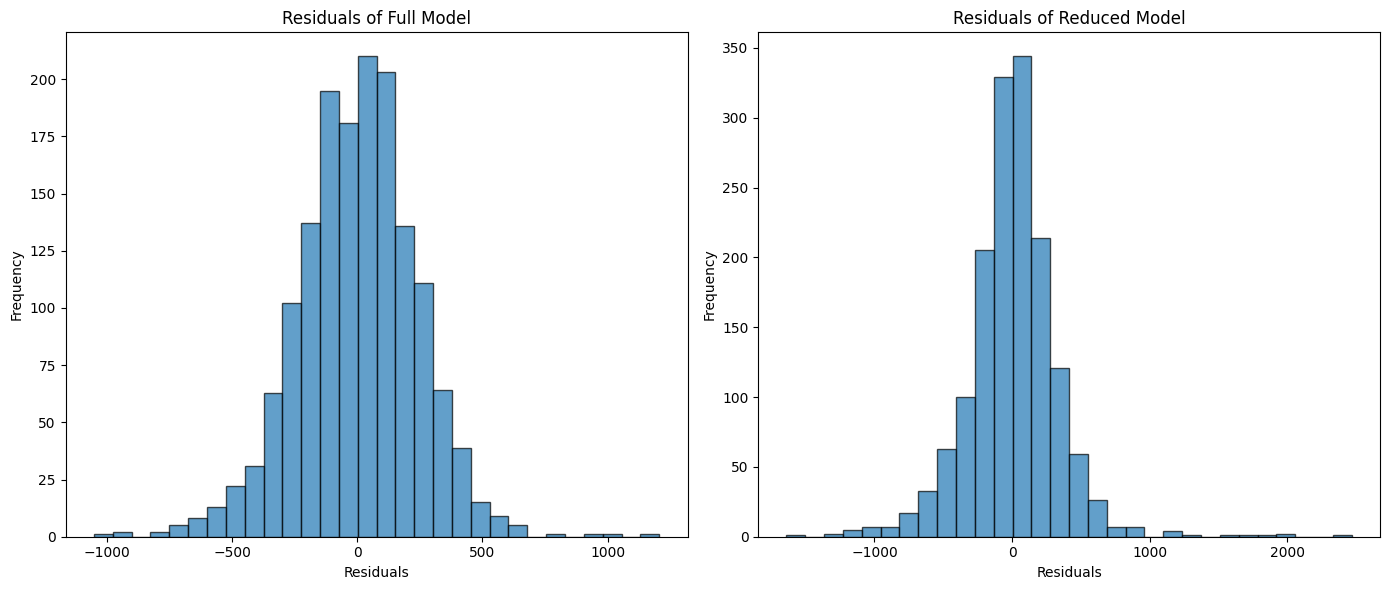

Summary statistics of residuals:

Full Model Residuals:
count    1.558000e+03
mean     1.897913e-11
std      2.368605e+02
min     -1.051960e+03
25%     -1.475157e+02
50%      7.878549e+00
75%      1.486791e+02
max      1.206408e+03
Name: resid_full, dtype: float64

Reduced Model Residuals:
count    1.558000e+03
mean     2.043152e-12
std      3.280749e+02
min     -1.639461e+03
25%     -1.565112e+02
50%      8.504867e+00
75%      1.672150e+02
max      2.466765e+03
Name: resid_reduced, dtype: float64
Error Metrics for Full Model:
RMSE: 232.34237765440747, MAE: 184.63588463076556, MAPE: 0.041403603986161934
Error Metrics for Reduced Model:
RMSE: 314.7729280852576, MAE: 224.95635723930673, MAPE: 0.05066733872485953
           df        sum_sq       mean_sq          F    PR(>F)
Model     1.0   2511.681335   2511.681335   2.957378  0.227626
Metric    2.0  80972.900416  40486.450208  47.670747  0.020546
Residual  2.0   1698.586786    849.293393        NaN       NaN


In [ ]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Create interaction terms
data['interaction_term'] = data['TMAX'] * data['TMIN']

# Prepare the full model (with interaction terms and temporal dependencies)
formula_full = 'previous_load_demand ~ previous_load_demand_lag_1 + previous_load_demand_lag_2 + previous_load_demand_lag_3 + WIND_SPEED + PRCP + SNOW + Snow_Depth + TMAX + TMIN + interaction_term'
model_full = ols(formula=formula_full, data=data).fit()

# Prepare the reduced model (without interaction terms)
formula_reduced = 'previous_load_demand ~ previous_load_demand_lag_1 + previous_load_demand_lag_2 + previous_load_demand_lag_3 + WIND_SPEED + PRCP + SNOW + Snow_Depth + TMAX + TMIN'
model_reduced = ols(formula=formula_reduced, data=data).fit()

# Perform ANOVA
anova_results = sm.stats.anova_lm(model_reduced, model_full)

print(anova_results)

# Interpret the results
if anova_results['Pr(>F)'][1] < 0.05:
    print("The interaction terms and temporal dependencies significantly improve the model.")
else:
    print("The interaction terms and temporal dependencies do not significantly improve the model.")

import matplotlib.pyplot as plt

# Plot residuals for both models
data['resid_full'] = model_full.resid
data['resid_reduced'] = model_reduced.resid

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(data['resid_full'], bins=30, edgecolor='k', alpha=0.7)
plt.title('Residuals of Full Model')
plt.xlabel('Residuals')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(data['resid_reduced'], bins=30, edgecolor='k', alpha=0.7)
plt.title('Residuals of Reduced Model')
plt.xlabel('Residuals')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Summary statistics of residuals
print("Summary statistics of residuals:")
print("\nFull Model Residuals:")
print(data['resid_full'].describe())
print("\nReduced Model Residuals:")
print(data['resid_reduced'].describe())

import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

# Prepare the features (X) and target (y)
X = data[['previous_load_demand_lag_1', 'previous_load_demand_lag_2', 'previous_load_demand_lag_3',
          'WIND_SPEED', 'PRCP', 'SNOW', 'Snow_Depth', 'TMAX', 'TMIN']]
y = data['previous_load_demand']

# Add interaction term for the full model
X_full = X.copy()
X_full['interaction_term'] = data['interaction_term']

# Split the data into training and validation sets
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X_full, y, test_size=0.2, random_state=42)
X_train_reduced, X_valid_reduced = X_train_full.drop(columns=['interaction_term']), X_valid_full.drop(columns=['interaction_term'])

# Fit the full model on the training set
model_full = ols(formula=formula_full, data=pd.concat([X_train_full, y_train], axis=1)).fit()

# Fit the reduced model on the training set
model_reduced = ols(formula=formula_reduced, data=pd.concat([X_train_reduced, y_train], axis=1)).fit()

# Make predictions on the validation set
y_pred_full = model_full.predict(X_valid_full)
y_pred_reduced = model_reduced.predict(X_valid_reduced)

# Calculate error metrics
rmse_full = np.sqrt(mean_squared_error(y_valid, y_pred_full))
mae_full = mean_absolute_error(y_valid, y_pred_full)
mape_full = mean_absolute_percentage_error(y_valid, y_pred_full)

rmse_reduced = np.sqrt(mean_squared_error(y_valid, y_pred_reduced))
mae_reduced = mean_absolute_error(y_valid, y_pred_reduced)
mape_reduced = mean_absolute_percentage_error(y_valid, y_pred_reduced)

print("Error Metrics for Full Model:")
print(f"RMSE: {rmse_full}, MAE: {mae_full}, MAPE: {mape_full}")

print("Error Metrics for Reduced Model:")
print(f"RMSE: {rmse_reduced}, MAE: {mae_reduced}, MAPE: {mape_reduced}")

import statsmodels.api as sm
from statsmodels.formula.api import ols
import pandas as pd

# Create a DataFrame with the errors
error_data = pd.DataFrame({
    'Model': ['Full', 'Full', 'Full', 'Reduced', 'Reduced', 'Reduced'],
    'Metric': ['RMSE', 'MAE', 'MAPE', 'RMSE', 'MAE', 'MAPE'],
    'Error': [rmse_full, mae_full, mape_full, rmse_reduced, mae_reduced, mape_reduced]
})

# Fit an ANOVA model to compare errors
formula_anova = 'Error ~ Model + Metric'
anova_model = ols(formula=formula_anova, data=error_data).fit()
anova_results = sm.stats.anova_lm(anova_model)

print(anova_results)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
           df        sum_sq        mean_sq         F    PR(>F)
Model     3.0  1.345578e+06  448525.948202  3.936228  0.072253
Metric    2.0  1.240914e+06  620456.906665  5.445081  0.044828
Residual  6.0  6.836889e+05  113948.151419       NaN       NaN
There is a significant difference in the performance metrics among the models.


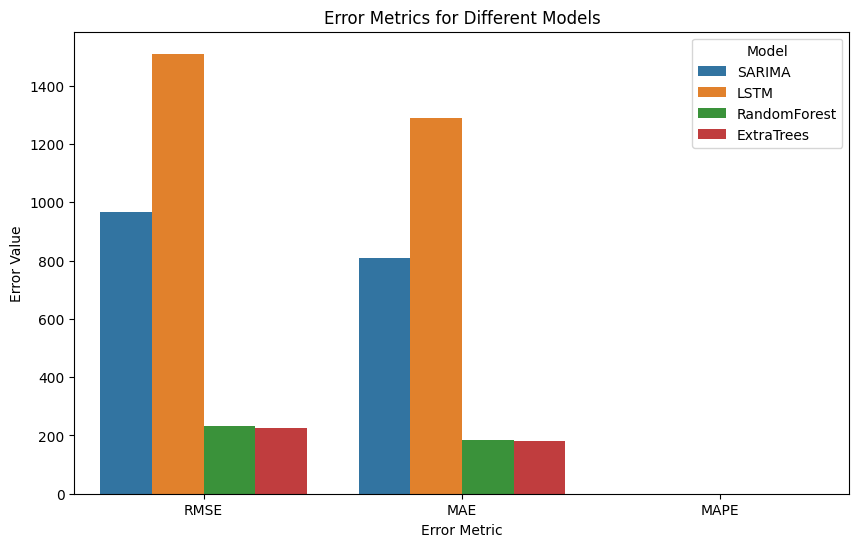

In [ ]:
import numpy as np
import pandas as pd
import joblib
from statsmodels.tsa.statespace.sarimax import SARIMAXResults
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from statsmodels.formula.api import ols
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# Load the scaler and models
scaler = joblib.load('scaler.pkl')
sarima_model1 = SARIMAXResults.load('sarima_model.pkl')
lstm_model1 = load_model('lstm_model.h5')
rf_model1 = joblib.load('rf_model.pkl')
et_model1 = joblib.load('et_model.pkl')

# Prepare the features (X) and target (y)
X = data[['previous_load_demand_lag_1', 'previous_load_demand_lag_2', 'previous_load_demand_lag_3',
          'WIND_SPEED', 'PRCP', 'SNOW', 'Snow_Depth', 'TMAX', 'TMIN']]
y = data['previous_load_demand']

# Split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the validation data
X_train_scaled = scaler.transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

# Make predictions using the SARIMA model
sarima_pred = sarima_model1.get_forecast(steps=len(y_valid)).predicted_mean

# Make predictions using the LSTM model
X_valid_lstm = X_valid_scaled.reshape((X_valid_scaled.shape[0], 1, X_valid_scaled.shape[1]))
lstm_pred = lstm_model1.predict(X_valid_lstm).flatten()

# Make predictions using the RandomForest model
rf_pred = rf_model1.predict(X_valid_scaled)

# Make predictions using the ExtraTrees model
et_pred = et_model1.predict(X_valid_scaled)

# Calculate error metrics for each model
models = {'SARIMA': sarima_pred, 'LSTM': lstm_pred, 'RandomForest': rf_pred, 'ExtraTrees': et_pred}
errors = {'Model': [], 'Metric': [], 'Error': []}

for model_name, predictions in models.items():
    rmse = np.sqrt(mean_squared_error(y_valid, predictions))
    mae = mean_absolute_error(y_valid, predictions)
    mape = mean_absolute_percentage_error(y_valid, predictions)

    errors['Model'].extend([model_name] * 3)
    errors['Metric'].extend(['RMSE', 'MAE', 'MAPE'])
    errors['Error'].extend([rmse, mae, mape])

error_data = pd.DataFrame(errors)

# Fit an ANOVA model to compare errors
formula_anova = 'Error ~ Model + Metric'
anova_model = ols(formula=formula_anova, data=error_data).fit()
anova_results = sm.stats.anova_lm(anova_model)

print(anova_results)

# Interpret the results
if anova_results['PR(>F)'][1] < 0.05:
    print("There is a significant difference in the performance metrics among the models.")
else:
    print("There is no significant difference in the performance metrics among the models.")

# Plot the error metrics for all models
plt.figure(figsize=(10, 6))
sns.barplot(x='Metric', y='Error', hue='Model', data=error_data)
plt.title('Error Metrics for Different Models')
plt.xlabel('Error Metric')
plt.ylabel('Error Value')
plt.legend(title='Model')
plt.show()
